# Model descomposition
### Modelos de descomposición

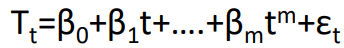

In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd,seaborn as sns

In [2]:
ts1 = pd.read_csv('/content/1.2_trend_1.txt', '\t', header = 0, usecols = ['Zt'])
ts1.head(3)

,Zt
0,88
1,94
2,98


## 0. Índice de fechas.

Los datos no especifican una fecha de inicio, pero se sabe que son datos mensuales que empiezan en el año 1, el cual asumiremos como el año 2000.

In [ ]:
ts1.index = pd.date_range('01-01-2000', periods = len(ts1), freq = 'M')
ts1.head(3)

,Zt
2000-01-31,88
2000-02-29,94
2000-03-31,98


# A. Trend: polynomial equation
## A. Tendencia: Descomposición polinómica

## 2. Cálculo de constantes

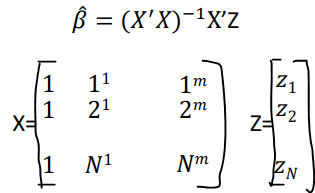

In [ ]:
m = 2  # Grado del polinomio
arr = np.arange(len(ts))+1
X_t = np.stack([np.power(arr,i) for i in range(m+1)])

X = X_t.transpose()
print(X_t.shape, '\n', X_t) 

(3, 50) 
 [[   1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1]
 [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
    15   16   17   18   19   20   21   22   23   24   25   26   27   28
    29   30   31   32   33   34   35   36   37   38   39   40   41   42
    43   44   45   46   47   48   49   50]
 [   1    4    9   16   25   36   49   64   81  100  121  144  169  196
   225  256  289  324  361  400  441  484  529  576  625  676  729  784
   841  900  961 1024 1089 1156 1225 1296 1369 1444 1521 1600 1681 1764
  1849 1936 2025 2116 2209 2304 2401 2500]]


In [ ]:
B = np.dot(np.linalg.inv(np.dot(X_t, X)), np.dot(X_t, ts['Zt']))
B

array([86.08357143,  3.6285989 , -0.09669522])

Mediante función

In [ ]:
def polynomic_eq(ts, m):
  lon = len(ts)
  arr = np.arange(lon)+1
  X_t = np.stack([np.power(arr,i) for i in range(m+1)])
  X = X_t.transpose()
  B = np.dot(np.linalg.inv(np.dot(X_t, X)), np.dot(X_t, ts))
  return list(B)

In [ ]:
B = polynomic_eq(ts = ts['Zt'], m = 2)
B  # Bo, B1, B2

[86.08357142857113, 3.6285989010989, -0.09669521654815796]

In [ ]:
a = polynomic_eq(ts['Zt'], m = 1)
a

[128.82285714285715, -1.302857142857142]

## 3. Estimación

In [ ]:
ts['Zt_est'] = [B[0] + B[1]*x + B[2]*x**2 for x in range(1, len(ts)+1)]
ts.tail()

,Zt,Zt_est
2003-10-31,48,48.392043
2003-11-30,45,43.027986
2003-12-31,38,37.470540
2004-01-31,33,31.719703
2004-02-29,23,25.775475


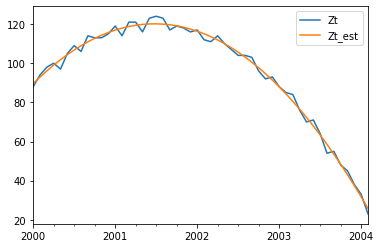

In [ ]:
ts.plot()

## 4. Pronóstico

In [ ]:
p = 4 # n° valores a pronosticar
ts_pron = [B[0] + B[1]*x + B[2]*x**2 for x in range(len(ts)+1, len(ts)+1 + p)]
ts_pron

[19.637857142856205, 13.306848739494797, 6.782449903037104, 0.064660633483129]

# B. Smoothing
## B. Suavizamiento

Básicamente es una media móvil de 2n+1 centrado.

In [ ]:
n = 2
ts_soft = ts['Zt'].rolling(2*n+1, center = True).mean()
ts_soft.head()

2000-01-31      NaN
2000-02-29      NaN
2000-03-31     95.4
2000-04-30     98.8
2000-05-31    101.8
Freq: M, Name: Zt, dtype: float64

Text(0, 0.5, 'Z')

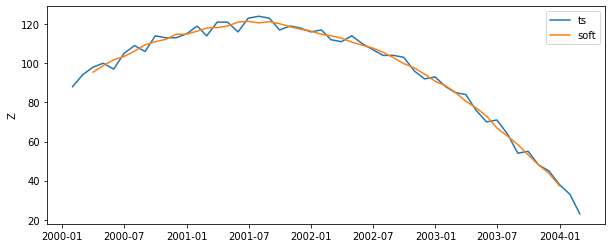

In [ ]:
fig, axes = plt.subplots(1, figsize = (10, 4))
axes.plot(ts.index, ts['Zt'], label = 'ts')
axes.plot(ts.index, ts_soft, label = 'soft')
axes.legend(); axes.set_ylabel('Z')

# C. Differencing
## C. Diferencias

# Funciones

In [ ]:
ts1.head(3)

,Zt
2000-01-31,88
2000-02-29,94
2000-03-31,98


In [ ]:
class ts:
  def __init__(self, ts):
    #===================================================================
    #| Input  |           Descripción             |       Type         |
    #|========|===================================|====================|
    #|   ts   | Serie de tiempo con DatetimeIndex | Serie or dataframe |
    #|==================================================================
    self.ts = ts       # Serie de tiempo
    self.N = len(ts)   # Longitud de serie de tiempo
    import pandas as pd
    self.df = pd.DataFrame({'t': range(1,self.N+1), 'Zt': self.ts['Zt']})
    return print('Objeto creado')

  ##### Modelos de descomposición: Tendencia #####
  def md_t_polynomic(self, m):
    # m: grado del polinomio
    import numpy as np
    arr = np.arange(self.N)+1; X_t = np.stack([np.power(arr,i) for i in range(m+1)])
    X = X_t.transpose(); self.B = np.dot(np.linalg.inv(np.dot(X_t, X)), np.dot(X_t, self.ts))

    z = np.power([np.full_like(np.arange(m+1), i) for i in range(1,self.N+1)],np.arange(m+1))
    z = np.multiply(z, self.B.transpose())
    self.T = pd.Series(np.sum(z, axis = 1)); self.df['T'] = self.T
    return print(f'Descomposición de tendencia: terminada\nEcuación de tendencia de grado {m}.')
  
  def md_t_smoothing(self, m=2, weighted=True, w=[0.1, 0.2, 0.4, 0.2, 0.1]):
    # m: Grado de suavizamiento
    import numpy as np
    if weighted == False:
      self.df['T'] = self.df['Zt'].rolling(2*m+1, center = True).mean()
    elif weighted == True:
      weights = np.array(w)
      self.df['T'] = self.df['Zt'].rolling(2*m+1, center = True).apply(lambda x: np.sum(weights*x))
    return print(f'Descomposición de tendencia: terminada\nSuavizamiento de m = {m}.')
  
  def md_t_differencing(self, m):
    i = 0
    self.df['T'] = self.df['Zt']
    while i <= m:
      self.df['T'] = self.df['T'].diff()
      i+=1
    return print(f'Diferenciación de orden {m} completada.')

  ##### Modelos de descomposición: estacionalidad #####
  def md_s_det(self, m):
    # m: grado del polinomio
    import numpy as np
    arr = np.arange(self.N)+1; X_t = np.stack([np.power(arr,i) for i in range(m+1)])
    X = X_t.transpose(); self.B = np.dot(np.linalg.inv(np.dot(X_t, X)), np.dot(X_t, self.ts))

    z = np.power([np.full_like(np.arange(m+1), i) for i in range(1,self.N+1)],np.arange(m+1))
    z = np.multiply(z, self.B.transpose())
    self.T = pd.Series(np.sum(z, axis = 1)); self.df['T'] = self.T
    return print(f'Descomposición de tendencia: terminada\nEcuación de tendencia de grado {m}.')


In [ ]:
exer1 = ts(ts1)

Objeto creado


In [ ]:
exer1.df.head(5)

,t,Zt,T
0,1,88,NaN
1,2,94,NaN
2,3,98,NaN
3,4,100,0.0
4,5,97,-3.0


In [ ]:
exer1.md_t_differencing(m = 2)

Diferenciación de orden 2 completada.


In [ ]:
exer1.md_t_polynomic(2)

Descomposición de tendencia: terminada
Ecuación de tendencia de grado 2


In [ ]:
exer1.md_t_smoothing(weighted=True)

Descomposición de tendencia: terminada
Suavizamiento de m = 2
